# Installations and Data Import from Kaggle

In [ ]:
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
!pip install tensorflow

In [ ]:
alessandrasala79_ai_vs_human_generated_dataset_path = kagglehub.dataset_download('alessandrasala79/ai-vs-human-generated-dataset')

print('Data source import complete.')

Data source import complete.


# PRO GAN

Running on 1 GPU(s)
Using 5000 samples → Train: 3000, Val: 1000, Test: 1000
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.4974 - loss: 0.6854 - val_accuracy: 0.5460 - val_loss: 0.6533
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.6500 - loss: 0.6272 - val_accuracy: 0.7570 - val_loss: 0.5826
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.7556 - loss: 0.5552 - val_accuracy: 0.7570 - val_loss: 0.4855
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.7971 - loss: 0.4757 - val_accuracy: 0.8550 - val_loss: 0.4477
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.8360 - loss: 0.4136 - val_accuracy: 0.8420 - val_loss: 0.3941
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.8516 - loss: 0.3575 - val_accuracy: 0.8140 - val_loss: 0.3334
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.8493 - loss: 0.3414 - val_accuracy: 0.8730 - val_loss: 0.3322
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━

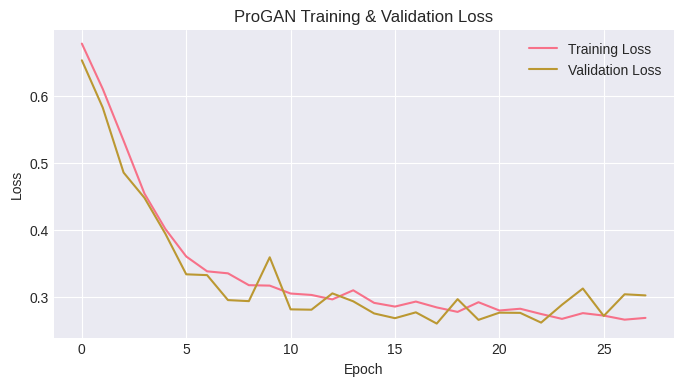

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

ProGAN Classification Report:
              precision    recall  f1-score   support

        fake       0.46      0.48      0.47       492
        real       0.48      0.46      0.47       508

    accuracy                           0.47      1000
   macro avg       0.47      0.47      0.47      1000
weighted avg       0.47      0.47      0.47      1000



<Figure size 640x480 with 0 Axes>

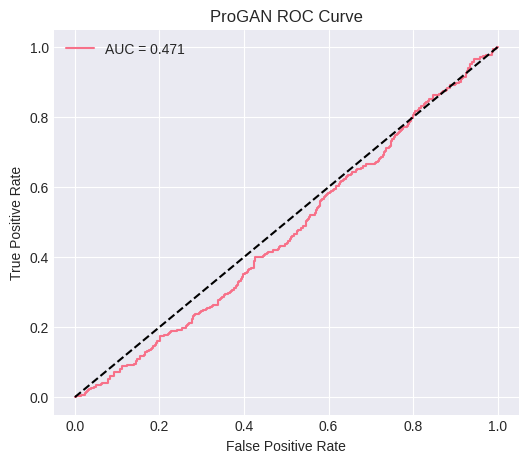

<Figure size 640x480 with 0 Axes>

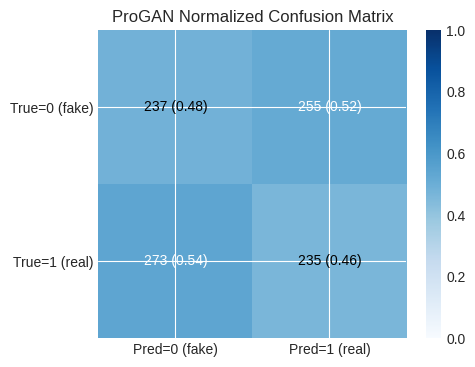


ProGAN results saved to progan_results.csv


<Figure size 640x480 with 0 Axes>

In [ ]:
# ProGAN Discriminator - AI vs Human Image Classification

import os, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import display

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# CONFIGURATION
NUM_IMAGES_TO_USE = 5000
SEED = 42

# Set random seeds
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# DETECT & CONFIGURE TPU/GPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except Exception:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"Running on {len(gpus)} GPU(s)")
        strategy = tf.distribute.MirroredStrategy()
    else:
        print("Running on CPU")
        strategy = tf.distribute.get_strategy()

# DATA LOADING
csv_path = "/kaggle/input/ai-vs-human-generated-dataset/train.csv"
img_dir = "/kaggle/input/ai-vs-human-generated-dataset/train_data"
df = pd.read_csv(csv_path)
df['label'] = df['label'].astype(int)
df['path'] = df['file_name'].map(lambda f: os.path.join(img_dir, os.path.basename(f)))

if NUM_IMAGES_TO_USE is not None:
    df = df.iloc[:NUM_IMAGES_TO_USE].copy()

df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

# 60/20/20 split
n = len(df)
train_ds = df.iloc[: int(0.6 * n)]
val_ds   = df.iloc[int(0.6 * n): int(0.8 * n)]
test_ds  = df.iloc[int(0.8 * n): ].reset_index(drop=True)
print(f"Using {n} samples → Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

train_paths, train_labels = train_ds['path'].tolist(), train_ds['label'].tolist()
val_paths,   val_labels   = val_ds['path'].tolist(),   val_ds['label'].tolist()
test_paths,  test_labels  = test_ds['path'].tolist(),  test_ds['label'].tolist()

# DATASET CREATION
IMG_SIZE = 64
BATCH    = 128

def preprocess(path):
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img_bytes, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img.set_shape([IMG_SIZE, IMG_SIZE, 3])
    return (img / 127.5) - 1.0

def make_labeled_ds(paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    def load(path, label):
        img = preprocess(path)
        return img, tf.expand_dims(label, axis=-1)
    ds = ds.map(load, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.shuffle(1000).batch(BATCH).prefetch(tf.data.AUTOTUNE)

train_ds = make_labeled_ds(train_paths, train_labels)
val_ds   = make_labeled_ds(val_paths,   val_labels)
test_ds  = make_labeled_ds(test_paths,  test_labels)

# PROGAN DISCRIMINATOR ARCHITECTURE (exact as your original)
latent_dim = 100

def build_progan_discriminator():
    D = keras.Sequential([
        layers.Input((IMG_SIZE,IMG_SIZE,3)),
        layers.Conv2D(32,3,padding="same"), layers.LeakyReLU(),
        layers.AveragePooling2D(pool_size=(2,2)),
        layers.Conv2D(64,3,padding="same"), layers.LeakyReLU(),
        layers.AveragePooling2D(pool_size=(2,2)),
        layers.Conv2D(128,3,padding="same"), layers.LeakyReLU(),
        layers.AveragePooling2D(pool_size=(2,2)),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return D

# TRAINING
with strategy.scope():
    D = build_progan_discriminator()

    D.compile(
        optimizer=keras.optimizers.Adam(2e-4, beta_1=0.5),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

history = D.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

# VISUALIZATIONS
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ProGAN Training & Validation Loss')
plt.legend()
plt.show()
plt.savefig('progan1.png', dpi=300)

# EVALUATION
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0).flatten()
y_logits = D.predict(test_ds)
y_prob = tf.sigmoid(y_logits).numpy().flatten()
y_pred = (y_prob >= 0.5).astype(int)

# Classification Report
print("\nProGAN Classification Report:")
print(classification_report(y_true, y_pred, target_names=["fake","real"]))

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ProGAN ROC Curve")
plt.legend()
plt.show()
plt.savefig('progan2.png', dpi=300)
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(5,4))
plt.imshow(cm_norm, cmap='Blues', vmin=0, vmax=1)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i,j]} ({cm_norm[i,j]:.2f})",
                 ha='center', va='center',
                 color='white' if cm_norm[i,j]>0.5 else 'black')
plt.xticks([0,1], ['Pred=0 (fake)','Pred=1 (real)'])
plt.yticks([0,1], ['True=0 (fake)','True=1 (real)'])
plt.title("ProGAN Normalized Confusion Matrix")
plt.colorbar()
plt.show()
plt.savefig('progan3.png', dpi=300)

# Save results
progan_results = {
    'Model': 'ProGAN',
    'AUC': roc_auc,
    'Accuracy': (y_pred == y_true).mean()
}
pd.DataFrame([progan_results]).to_csv('progan_results.csv', index=False)
print("\nProGAN results saved to progan_results.csv")

# STYLE GAN

Running on 1 GPU(s)


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5445 - loss: 0.6727 - val_accuracy: 0.6920 - val_loss: 0.5730
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7105 - loss: 0.5546 - val_accuracy: 0.7810 - val_loss: 0.4585
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8123 - loss: 0.4269 - val_accuracy: 0.8540 - val_loss: 0.3351
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8672 - loss: 0.3286 - val_accuracy: 0.8720 - val_loss: 0.3018
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8840 - loss: 0.2911 - val_accuracy: 0.8780 - val_loss: 0.2932
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8865 - loss: 0.2744 - val_accuracy: 0.8800 - val_loss: 0.2715
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9112 - loss: 0.2385 - val_accuracy: 0.8750 - val_loss: 0.2824
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9187 - loss: 0.2209 - val_accuracy: 0.8890 - v

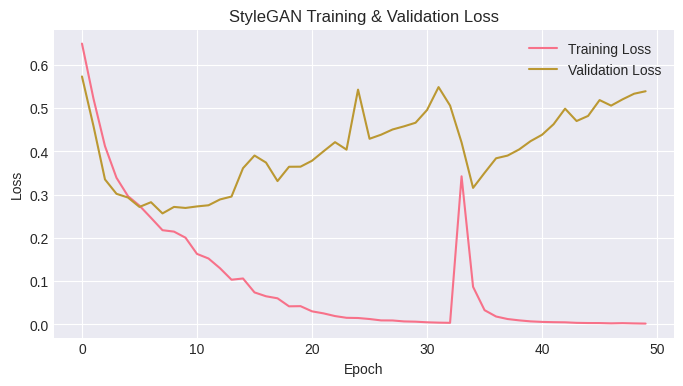

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step

StyleGAN Classification Report:
              precision    recall  f1-score   support

        fake       0.85      0.88      0.87       500
        real       0.87      0.85      0.86       500

    accuracy                           0.86      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.86      0.86      0.86      1000



<Figure size 640x480 with 0 Axes>

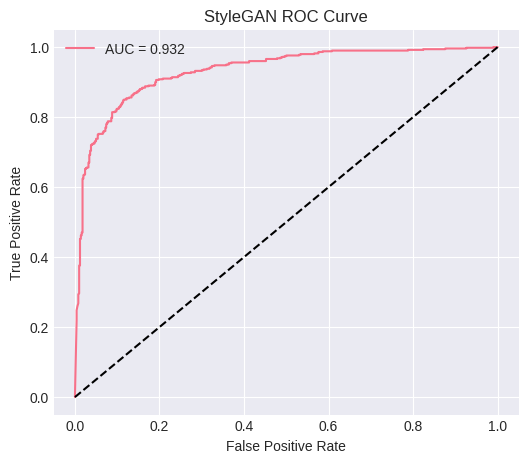

<Figure size 640x480 with 0 Axes>

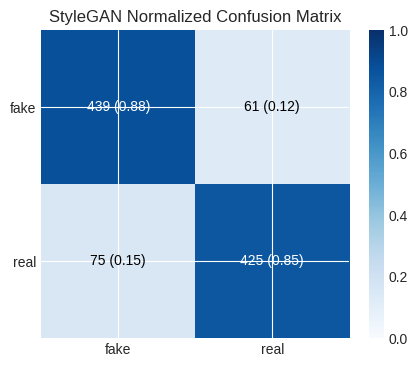


StyleGAN results saved to stylegan_results.csv


<Figure size 640x480 with 0 Axes>

In [ ]:
# StyleGAN Discriminator - AI vs Human Image Classification

import os, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# CONFIGURATION
NUM_IMAGES_TO_USE = 5000
SEED = 42

# Set random seeds
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# DETECT & CONFIGURE TPU/GPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except Exception:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"Running on {len(gpus)} GPU(s)")
        strategy = tf.distribute.MirroredStrategy()
    else:
        print("Running on CPU")
        strategy = tf.distribute.get_strategy()

# DATA LOADING
csv_path = "/kaggle/input/ai-vs-human-generated-dataset/train.csv"
img_dir = "/kaggle/input/ai-vs-human-generated-dataset/train_data"
df = pd.read_csv(csv_path)

if df['label'].dtype == object:
    df['label'] = (df['label'] == 'fake').astype('int32')
else:
    df['label'] = df['label'].astype('int32')

if NUM_IMAGES_TO_USE is not None:
    df = df.iloc[:NUM_IMAGES_TO_USE].copy()

# DATASET CREATION
IMG_SIZE = 64
BATCH_SIZE = 64

def preprocess(path, label):
    filename = tf.strings.regex_replace(path, ".*/", "")
    full_path = tf.strings.join([img_dir, filename], separator="/")
    img = tf.io.read_file(full_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = (img - 127.5) / 127.5
    return img, label

def make_dataset(df):
    paths = df['file_name'].astype(str).values
    labels = df['label'].astype('int32').values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(2048, seed=SEED).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

# Split data
train_df, val_df, test_df = np.split(df, [int(.6*len(df)), int(.8*len(df))])
train_ds = make_dataset(train_df)
val_ds   = make_dataset(val_df)
test_ds  = make_dataset(test_df)

# STYLEGAN DISCRIMINATOR ARCHITECTURE (exact as your original)
class PixelNormalization(layers.Layer):
    def call(self, inputs):
        return inputs / tf.sqrt(tf.reduce_mean(inputs**2, axis=-1, keepdims=True) + 1e-8)

class ConvBlock(layers.Layer):
    def __init__(self, filters):
        super().__init__()
        self.conv1 = layers.Conv2D(filters, 3, padding="same")
        self.conv2 = layers.Conv2D(filters, 3, padding="same")
        self.act   = layers.LeakyReLU(0.2)
        self.pn    = PixelNormalization()
    def call(self, x):
        x = self.conv1(x); x = self.act(x); x = self.pn(x)
        x = self.conv2(x); x = self.act(x); x = self.pn(x)
        return x

def build_discriminator(img_size=64):
    inp = layers.Input(shape=(img_size, img_size, 3))
    x = inp
    filters = [64,128,256,512]
    for f in filters:
        x = layers.Conv2D(f, 3, strides=2, padding="same")(x)
        x = layers.LeakyReLU(0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inp, x, name="discriminator")

# TRAINING
with strategy.scope():
    discriminator = build_discriminator(img_size=IMG_SIZE)
    discriminator.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(2e-4, beta_1=0.5),
        metrics=['accuracy']
    )

history = discriminator.fit(train_ds, validation_data=val_ds, epochs=50)

# VISUALIZATIONS
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('StyleGAN Training & Validation Loss')
plt.legend()
plt.show()
plt.savefig('stylegan1.png', dpi=300)
# EVALUATION
y_true, y_pred, y_prob = [], [], []
for x_batch, y_batch in test_ds:
    probs = discriminator.predict(x_batch).flatten()
    preds = (probs > 0.5).astype(int)
    y_true.extend(y_batch.numpy())
    y_prob.extend(probs.tolist())
    y_pred.extend(preds.tolist())

# Classification Report
print("\nStyleGAN Classification Report:")
print(classification_report(y_true, y_pred, labels=[0,1], target_names=['fake','real']))

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("StyleGAN ROC Curve")
plt.legend()
plt.show()
plt.savefig('stylegan2.png', dpi=300)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(5,4))
plt.imshow(cm_norm, cmap='Blues', vmin=0, vmax=1)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i,j]} ({cm_norm[i,j]:.2f})",
                 ha='center', va='center',
                 color='white' if cm_norm[i,j]>0.5 else 'black')
plt.xticks([0,1], ['fake','real'])
plt.yticks([0,1], ['fake','real'])
plt.title("StyleGAN Normalized Confusion Matrix")
plt.colorbar()
plt.show()
plt.savefig('stylegan3.png', dpi=300)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Save results
stylegan_results = {
    'Model': 'StyleGAN',
    'AUC': roc_auc,
    'Accuracy': (y_pred == y_true).mean()
}
pd.DataFrame([stylegan_results]).to_csv('stylegan_results.csv', index=False)
print("\nStyleGAN results saved to stylegan_results.csv")

# GJOB GAN

Running on 1 GPU(s)
Train: 3000, Val: 1000, Test: 1000
Loaded training images: (3000, 64, 64, 3)
Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6267 - loss: 0.7920 - val_accuracy: 0.5733 - val_loss: 1.2364
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7846 - loss: 0.4848 - val_accuracy: 0.5900 - val_loss: 1.2876
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8378 - loss: 0.3969 - val_accuracy: 0.6033 - val_loss: 1.2479
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8286 - loss: 0.4012 - val_accuracy: 0.6217 - val_loss: 1.2020
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8424 - loss: 0.3639 - val_accuracy: 0.6200 - val_loss: 1.2153
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8706 - loss: 0.3493 - val_accuracy: 0.6183 - val_loss: 1.2592
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8557 - loss: 0.3308 - val_accuracy: 0.6400 - val_loss: 1.0762
Epoch 8/50
75/

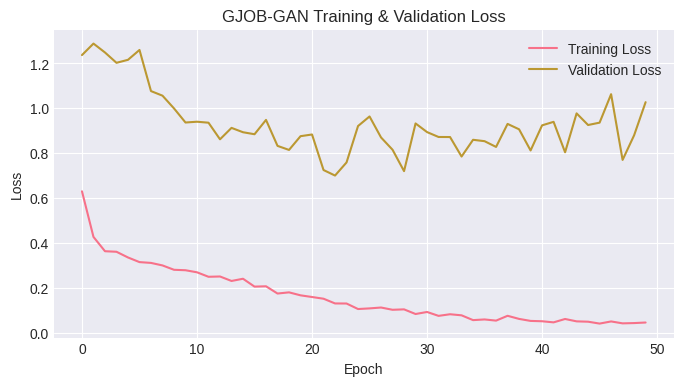


GJOB-GAN Classification Report:
              precision    recall  f1-score   support

        fake       0.76      0.97      0.85       500
        real       0.96      0.69      0.80       500

    accuracy                           0.83      1000
   macro avg       0.86      0.83      0.83      1000
weighted avg       0.86      0.83      0.83      1000



<Figure size 640x480 with 0 Axes>

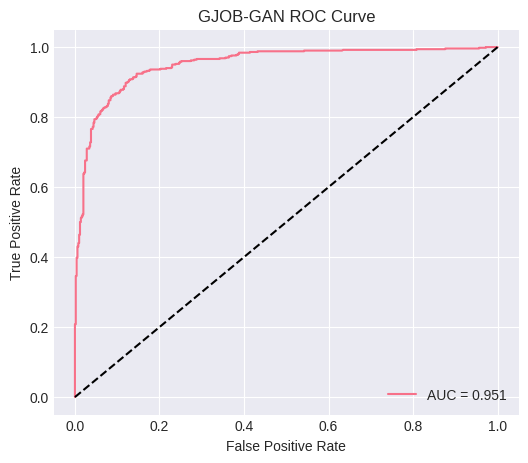

<Figure size 640x480 with 0 Axes>

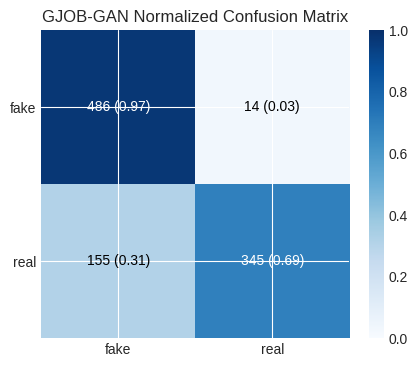


GJOB-GAN results saved to gjob_results.csv


<Figure size 640x480 with 0 Axes>

In [ ]:
# GJOB-GAN Discriminator - AI vs Human Image Classification

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    classification_report
)

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seeds
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# DETECT & CONFIGURE TPU/GPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except Exception:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"Running on {len(gpus)} GPU(s)")
        strategy = tf.distribute.MirroredStrategy()
    else:
        print("Running on CPU")
        strategy = tf.distribute.get_strategy()

# CONFIGURATION
CSV_PATH = "/kaggle/input/ai-vs-human-generated-dataset/train.csv"
DATA_DIR = "/kaggle/input/ai-vs-human-generated-dataset/train_data"
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
LATENT_DIM = 100
EPOCHS = 50
NUM_IMAGES = 5000  # Match other models

# UTILITIES
def load_images(filepaths, img_size):
    imgs = []
    for fp in filepaths:
        img = tf.keras.preprocessing.image.load_img(fp, target_size=img_size)
        arr = tf.keras.preprocessing.image.img_to_array(img)
        imgs.append(arr)
    X = np.array(imgs, dtype=np.float32)
    return (X - 127.5) / 127.5  # normalize to [-1, +1]

# G-JOB GAN DISCRIMINATOR (exact as your original)
def build_discriminator(img_shape=(64,64,3)):
    model = models.Sequential([
        layers.Input(shape=img_shape),
        layers.Conv2D(32, 3, 2, 'same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.25),

        layers.Conv2D(64, 3, 2, 'same'),
        layers.BatchNormalization(momentum=0.8),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.25),

        layers.Conv2D(128, 3, 2, 'same'),
        layers.BatchNormalization(momentum=0.8),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.25),

        layers.Conv2D(256, 3, 2, 'same'),
        layers.BatchNormalization(momentum=0.8),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.5),
        layers.Dense(256),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.5),

        layers.Dense(1, activation='sigmoid'),
    ])
    img = layers.Input(shape=img_shape)
    return models.Model(img, model(img))

# DATA LOADING & PREPARATION
df = pd.read_csv(CSV_PATH)

# Use same number of images as other models
if NUM_IMAGES is not None:
    df = df.iloc[:NUM_IMAGES].copy()

df["filepath"] = df["file_name"].apply(lambda x: os.path.join(DATA_DIR, os.path.basename(x)))

# 60/20/20 split stratified
train_df, temp_df = train_test_split(
    df, test_size=0.4, stratify=df["label"], random_state=SEED
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=SEED
)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Load ONLY the training images into memory
X_train = load_images(train_df["filepath"].tolist(), IMG_SIZE)
print("Loaded training images:", X_train.shape)

# BUILD & COMPILE DISCRIMINATOR
with strategy.scope():
    discriminator = build_discriminator(img_shape=(*IMG_SIZE, 3))
    discriminator.compile(
        loss='binary_crossentropy',
        optimizer=optimizers.Adam(2e-4, beta_1=0.5),
        metrics=['accuracy']
    )

# TRAINING LOOP (simplified from your original)
# Since we're training discriminator directly as a classifier, not a GAN
y_train = train_df["label"].values.astype(np.float32)
history = discriminator.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    shuffle=True
)

# VISUALIZATIONS
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GJOB-GAN Training & Validation Loss')
plt.legend()
plt.show()
plt.savefig('gjobgan1.png', dpi=300)

# EVALUATION on held-out data
def evaluate_on_dataset(discriminator, df, img_size, batch_size):
    filepaths = df["filepath"].tolist()
    y_true = df["label"].astype(int).values
    preds = []
    probs = []

    for i in range(0, len(filepaths), batch_size):
        batch_fps = filepaths[i:i + batch_size]
        batch_imgs = load_images(batch_fps, img_size)
        p = discriminator.predict(batch_imgs, verbose=0)
        preds.append((p.flatten() > 0.5).astype(int))
        probs.append(p.flatten())

    preds = np.concatenate(preds)
    probs = np.concatenate(probs)

    # Classification Report
    print("\nGJOB-GAN Classification Report:")
    print(classification_report(y_true, preds, target_names=["fake","real"]))

    return y_true, preds, probs

# Evaluate on test set
y_true, y_pred, y_prob = evaluate_on_dataset(discriminator, test_df, IMG_SIZE, BATCH_SIZE)

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("GJOB-GAN ROC Curve")
plt.legend()
plt.show()
plt.savefig('gjobgan2.png', dpi=300)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(5,4))
plt.imshow(cm_norm, cmap='Blues', vmin=0, vmax=1)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i,j]} ({cm_norm[i,j]:.2f})",
                 ha='center', va='center',
                 color='white' if cm_norm[i,j]>0.5 else 'black')
plt.xticks([0,1], ['fake','real'])
plt.yticks([0,1], ['fake','real'])
plt.title("GJOB-GAN Normalized Confusion Matrix")
plt.colorbar()
plt.show()
plt.savefig('gjobgan3.png', dpi=300)

# Save results
gjob_results = {
    'Model': 'GJOB-GAN',
    'AUC': roc_auc,
    'Accuracy': accuracy_score(y_true, y_pred)
}
pd.DataFrame([gjob_results]).to_csv('gjob_results.csv', index=False)
print("\nGJOB-GAN results saved to gjob_results.csv")

# TIMM Library

torch.Size([16, 3, 384, 384]) tensor([1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0])
torch.Size([16, 3, 384, 384]) tensor([1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0])


model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

Epoch 1/2
--------------------------------------------------


Training:  29%|██▊       | 1001/3498 [03:29<14:08:19, 20.38s/it]

New best model saved with F1 score: 0.9357
Train Loss: 1.1230, Train Acc: 0.8440
Val Loss: 0.3396, Val Acc: 0.9358, Val F1: 0.9357


Training:  57%|█████▋    | 2001/3498 [06:19<5:22:52, 12.94s/it]

New best model saved with F1 score: 0.9680
Train Loss: 0.2141, Train Acc: 0.9599
Val Loss: 0.1767, Val Acc: 0.9680, Val F1: 0.9680


Training:  86%|████████▌ | 3001/3498 [09:09<1:25:27, 10.32s/it]

New best model saved with F1 score: 0.9694
Train Loss: 0.1446, Train Acc: 0.9712
Val Loss: 0.1703, Val Acc: 0.9694, Val F1: 0.9694


Training: 100%|██████████| 3498/3498 [10:03<00:00,  5.79it/s]

Epoch 2/2
--------------------------------------------------



Training:  14%|█▍        | 503/3498 [01:56<10:46:04, 12.94s/it]

Train Loss: 0.2509, Train Acc: 0.9537
Val Loss: 0.3063, Val Acc: 0.9417, Val F1: 0.9416


Training:  43%|████▎     | 1503/3498 [04:45<6:12:26, 11.20s/it]

Train Loss: 0.2430, Train Acc: 0.9493
Val Loss: 0.3057, Val Acc: 0.9419, Val F1: 0.9419


Training:  72%|███████▏  | 2503/3498 [07:32<3:20:41, 12.10s/it]

Train Loss: 0.2438, Train Acc: 0.9489
Val Loss: 0.3057, Val Acc: 0.9419, Val F1: 0.9419


Training: 100%|██████████| 3498/3498 [09:18<00:00,  6.26it/s]


Training complete.
Best F1 Score: 0.9694


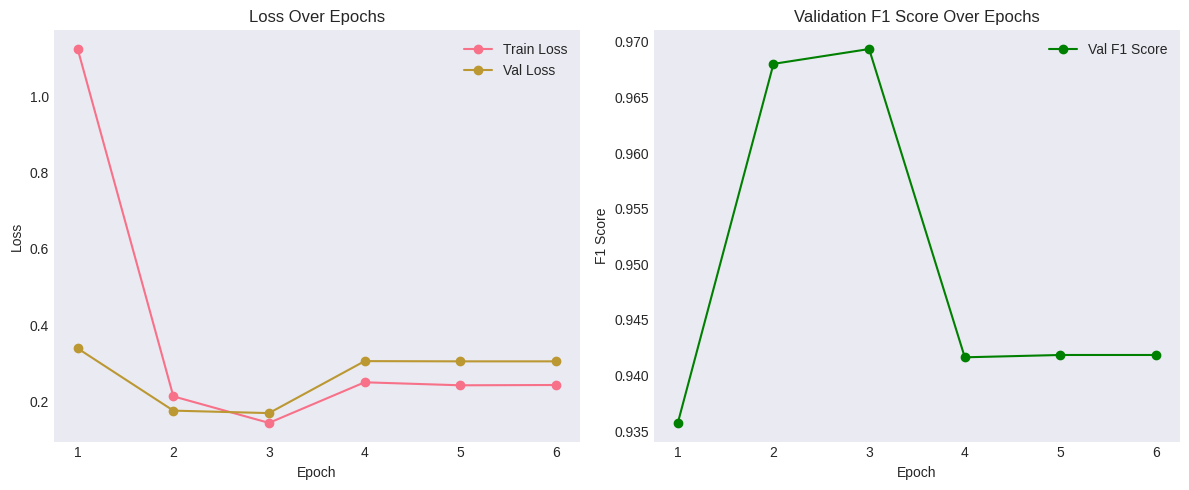

Evaluating: 100%|██████████| 1500/1500 [01:03<00:00, 23.74it/s]


EfficientNetV2 Classification Report:
              precision    recall  f1-score   support

        fake       0.97      0.97      0.97     11993
        real       0.97      0.97      0.97     11992

    accuracy                           0.97     23985
   macro avg       0.97      0.97      0.97     23985
weighted avg       0.97      0.97      0.97     23985



<Figure size 640x480 with 0 Axes>

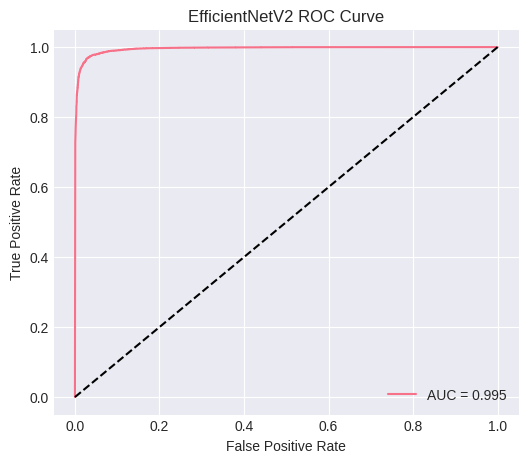

<Figure size 640x480 with 0 Axes>

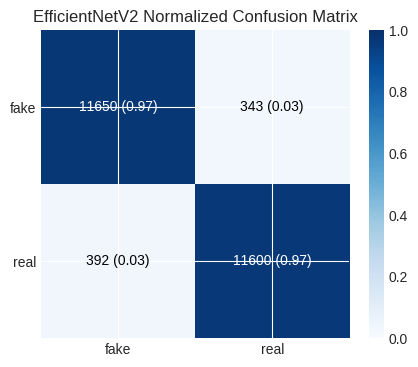


EfficientNetV2 results saved to efficientnet_results.csv


<Figure size 640x480 with 0 Axes>

In [ ]:
# EfficientNetV2 - AI vs Human Image Classification

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, accuracy_score

import timm
import albumentations as albu
from albumentations.pytorch import ToTensorV2
from PIL import Image
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from torch.optim import AdamW, Adam
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import f1_score
from tqdm import tqdm
import copy

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# CONFIGURATION (exact as your original)
BATCH_SIZE = 16
SEED = 42
IMG_SIZE = 384
LR = 1e-5
NUM_EPOCHS = 2

# DATASET (exact as your original)
class CustomDataset(Dataset):
    def __init__(self, df, data_dir, transforms=None, is_train=True):
        """
        Args:
            df (pd.DataFrame): DataFrame containing file names and labels.
            data_dir (str): Directory where images are stored.
            transforms (albu.Compose, optional): Albumentations transforms to apply to the images.
            is_train (bool, optional): Flag to indicate if the dataset is for training.
        """
        self.df = df
        self.data_dir = data_dir
        self.transforms = transforms
        self.is_train = is_train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Extract the file name and label
        filename = self.df.iloc[idx]['file_name']
        label = self.df.iloc[idx]['label']

        # Load the image
        img_path = os.path.join(self.data_dir, filename)
        image = Image.open(img_path).convert('RGB')  # Ensure image is in RGB mode
        image = np.array(image)  # Convert to NumPy array (Albumentations requires this format)

        # Apply transforms if specified
        if self.transforms:
            image = self.transforms(image=image)['image']

        # For training, return the image and label
        if self.is_train:
            return image, label
        # For inference, return only the image
        else:
            return image

# DATA LOADING (exact as your original)
train_csv_path = "/kaggle/input/ai-vs-human-generated-dataset/train.csv"
train_df = pd.read_csv(train_csv_path)

# Define the base directory where images are stored
train_data_dir = "/kaggle/input/ai-vs-human-generated-dataset/"

# TRANSFORMS (exact as your original)
train_transform = albu.Compose([
    albu.HorizontalFlip(p=0.5),
    albu.Resize(IMG_SIZE, IMG_SIZE),
    albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = albu.Compose([
    albu.Resize(IMG_SIZE, IMG_SIZE),
    albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# SPLIT DATA (exact as your original)
train_df, val_df = train_test_split(train_df, test_size=0.3, random_state=SEED, stratify=train_df['label'])

# DATASET & DATALOADER (exact as your original)
train_dataset = CustomDataset(train_df, train_data_dir, transforms=train_transform, is_train=True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

val_dataset = CustomDataset(val_df, train_data_dir, transforms=val_transform, is_train=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Iterate through the DataLoader
for images, labels in train_dataloader:
    print(images.shape, labels)
    break

for images, labels in val_dataloader:
    print(images.shape, labels)
    break

# MODEL (exact as your original)
model = timm.create_model('tf_efficientnetv2_s.in21k_ft_in1k',
                          pretrained=True,
                          num_classes=2)

optimizer = Adam(model.parameters(), lr=LR, weight_decay=1e-2)
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
loss_fn = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# TRAINING FUNCTION (exact as your original)
def train_model(
    model, train_loader, val_loader, optimizer, scheduler, loss_fn, device, num_epochs=10, save_path="best_model.pth"
):
    """
    Trains the model and evaluates it on the validation set. Saves the model with the best F1 score.

    Args:
        model: The PyTorch model to train.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        optimizer: Optimizer, e.g., AdamW.
        scheduler: Learning rate scheduler, e.g., StepLR.
        loss_fn: Loss function, e.g., CrossEntropyLoss.
        device: Device to train on (e.g., 'cuda' or 'cpu').
        num_epochs: Number of epochs to train.
        save_path: Path to save the model with the best F1 score.

    Returns:
        best_model_wts: The weights of the model with the highest F1 score.
        history: A dictionary containing training and validation metrics.
    """
    model.to(device)  # Move model to the specified device

    best_f1 = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())  # To store the best weights
    history = {"train_loss": [], "val_loss": [], "val_f1": []}

    curr_step = 0
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 50)

        # Training phase
        model.train()

        for batch_idx, (images, labels) in tqdm(enumerate(train_loader), desc="Training", total=len(train_loader)):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(images)  # Forward pass
            loss = loss_fn(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            # Compute training metrics
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

            curr_step += 1
            if curr_step % 1000 == 0:
                # Validation phase
                model.eval()
                val_loss = 0.0
                val_correct = 0
                val_total = 0
                all_labels = []
                all_preds = []

                with torch.no_grad():
                    for images, labels in val_loader:
                        images, labels = images.to(device), labels.to(device)

                        outputs = model(images)
                        loss = loss_fn(outputs, labels)

                        val_loss += loss.item()
                        _, preds = torch.max(outputs, 1)

                        val_correct += (preds == labels).sum().item()
                        val_total += labels.size(0)

                        # Store labels and predictions for F1 score calculation
                        all_labels.extend(labels.cpu().numpy())
                        all_preds.extend(preds.cpu().numpy())

                val_loss /= len(val_loader)
                val_f1 = f1_score(all_labels, all_preds, average="weighted")

                # Save the best model weights based on validation F1 score
                if val_f1 > best_f1:
                    best_f1 = val_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), save_path)
                    print(f"New best model saved with F1 score: {best_f1:.4f}")

                train_loss /= 1000

                # Log metrics
                history["train_loss"].append(train_loss)
                history["val_loss"].append(val_loss)
                history["val_f1"].append(val_f1)

                # Print results after 1k steps
                train_acc = train_correct / train_total
                val_acc = val_correct / val_total
                print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
                print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

                # reset
                train_loss = 0.0
                train_total = 0
                train_correct = 0

                # Step the learning rate scheduler
                scheduler.step()

    print("Training complete.")
    print(f"Best F1 Score: {best_f1:.4f}")
    return best_model_wts, history

# TRAIN THE MODEL
best_model_wts, history = train_model(
    model=model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    device=device,
    num_epochs=NUM_EPOCHS,
    save_path="best_model.pth",
)

# Load the best model weights after training
model.load_state_dict(best_model_wts)

# VISUALIZATION FUNCTION (exact as your original)
def visualize_history(history):
    """
    Visualizes the training and validation history.

    Args:
        history (dict): Dictionary containing training and validation metrics with keys:
                        - "train_loss": List of training loss values.
                        - "val_loss": List of validation loss values.
                        - "val_f1": List of validation F1 scores.
    """
    epochs = range(1, len(history["train_loss"]) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Val Loss", marker="o")
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    # Plot validation F1 score
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["val_f1"], label="Val F1 Score", marker="o", color="green")
    plt.title("Validation F1 Score Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    plt.savefig('timm1.png', dpi=300)
visualize_history(history)

# EVALUATION
model.eval()

y_true = []
y_pred = []
y_prob = []

with torch.no_grad():
    for images, labels in tqdm(val_dataloader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_prob.extend(probs[:, 1].cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# Classification Report
print("\nEfficientNetV2 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["fake","real"]))

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("EfficientNetV2 ROC Curve")
plt.legend()
plt.show()
plt.savefig('timm2.png', dpi=300)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(5,4))
plt.imshow(cm_norm, cmap='Blues', vmin=0, vmax=1)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i,j]} ({cm_norm[i,j]:.2f})",
                 ha='center', va='center',
                 color='white' if cm_norm[i,j]>0.5 else 'black')
plt.xticks([0,1], ['fake','real'])
plt.yticks([0,1], ['fake','real'])
plt.title("EfficientNetV2 Normalized Confusion Matrix")
plt.colorbar()
plt.show()
plt.savefig('timm3.png', dpi=300)

# Save results
efficientnet_results = {
    'Model': 'EfficientNetV2',
    'AUC': roc_auc,
    'Accuracy': accuracy_score(y_true, y_pred)
}
pd.DataFrame([efficientnet_results]).to_csv('efficientnet_results.csv', index=False)
print("\nEfficientNetV2 results saved to efficientnet_results.csv")